In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG19
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
!pip uninstall pydot
!pip uninstall graphviz


In [15]:
# Define the paths
benign_folder = 'Thyroid Dataset/benign/'
malignant_folder = 'Thyroid Dataset/malignant/'

# Create a list of image paths and labels
benign_images = [os.path.join(benign_folder, img) for img in os.listdir(benign_folder)]
malignant_images = [os.path.join(malignant_folder, img) for img in os.listdir(malignant_folder)]

all_images = benign_images + malignant_images
labels = [0] * len(benign_images) + [1] * len(malignant_images)

# Convert labels to strings
labels = [str(label) for label in labels]

# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(all_images, labels, test_size=0.2, random_state=42)

# Create data generators
train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2, rotation_range=20)
val_datagen = ImageDataGenerator(rescale=1.0/255)

def create_data_generator(datagen, images, labels, batch_size=32):
    data = {'filename': images, 'class': labels}
    df = pd.DataFrame(data)
    generator = datagen.flow_from_dataframe(df, x_col='filename', y_col='class', class_mode='binary', target_size=(150, 150), batch_size=batch_size)
    return generator

train_generator = create_data_generator(train_datagen, train_images, train_labels)
val_generator = create_data_generator(val_datagen, val_images, val_labels)


Found 251 validated image filenames belonging to 2 classes.
Found 64 validated image filenames belonging to 2 classes.


C:\Users\atray\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [5]:


# Load the pre-trained VGG19 model without the top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary to check the architecture
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,155,969 (76.89 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [24]:
# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the model architecture within Jupyter Notebook (optional)
from IPython.display import Image
Image('model_architecture.png')

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [6]:
# Train the model
history = model.fit(train_generator, epochs=20, validation_data=val_generator)

Epoch 1/20


C:\Users\atray\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5962 - loss: 0.7331 - val_accuracy: 0.5312 - val_loss: 0.6968
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5259 - loss: 0.7300 - val_accuracy: 0.6250 - val_loss: 0.6693
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4989 - loss: 0.7736 - val_accuracy: 0.5000 - val_loss: 0.6993
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5547 - loss: 0.7234 - val_accuracy: 0.6094 - val_loss: 0.6618
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5865 - loss: 0.7036 - val_accuracy: 0.6094 - val_loss: 0.6580
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5427 - loss: 0.7565 - val_accuracy: 0.6094 - val_loss: 0.6743
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5401 - loss: 0.6965 - val_accuracy: 0.6094 - val_loss: 0.6777
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5027 - loss: 0.7667 - val_accuracy: 0.6250 - val_loss: 0.6664
Epoch 9/20
8/8 ━━━━

In [21]:
# Save the model
model.save('thyroid_nodule_classifier.h5')

C:\Users\atray\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


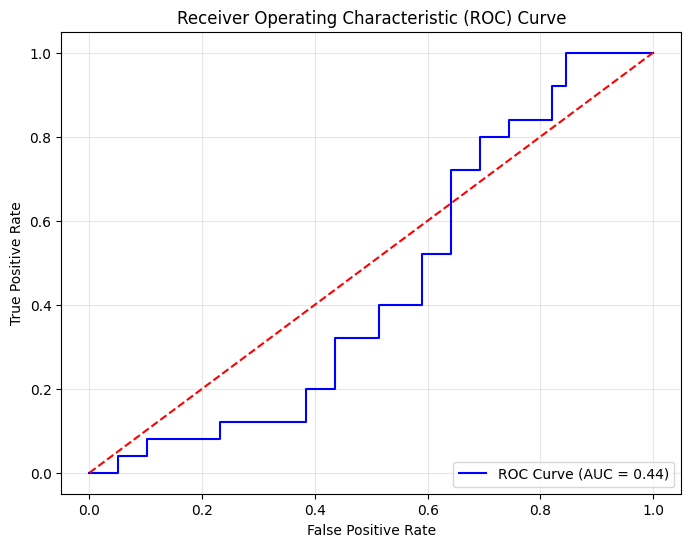

In [16]:

# Predict probabilities for the test set
y_probs = model.predict(val_generator)
y_true = val_generator.classes

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
# Calculate the AUC score
auc_score = roc_auc_score(y_true, y_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
The predicted class for the image is: benign


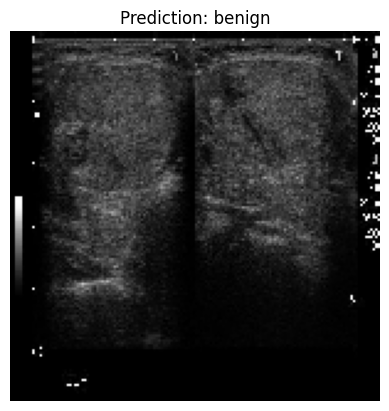

In [23]:
#img_path = 'Thyroid Dataset/malignant/162_1.jpg'  # Make sure to enclose the path in quotes
img_path ='Thyroid Dataset/benign/100_1.jpg'
pred = img_path.split('/')[1]

def predict_image(model, image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Make a prediction
    prediction = model.predict(img_array)
     
    
    # Return the class based on the prediction
    return 'malignant' if prediction[0][0] > 0.5 else 'benign'

# Load the saved model
model = tf.keras.models.load_model('thyroid_nodule_classifier.h5')

# Example prediction using the defined img_path
prediction = predict_image(model, img_path)  # Use the correct path to the image you want to predict
print(f'The predicted class for the image is: {prediction}')

# Display the image
img = load_img(img_path, target_size=(150, 150))
plt.imshow(img)
plt.title(f'Prediction: {pred}')
plt.axis('off')
plt.show()